In [ ]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import evaluate

import csv
from collections import defaultdict

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-15 10:23:23.327288: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 10:23:23.331963: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 10:23:23.394476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 10:23:24.356360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
DATASET_DIR = 'data/full_maven_with_category.csv'

## Load Dataset

In [6]:

def load_dataset(file_location, target_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_location)
    labels = sorted(list(df[target_column].unique()))
    print(len(labels))

    #convert labels in target column to numbers
    df[target_column] = df[target_column].apply(lambda x: labels.index(x))

    return df, labels

In [7]:
data_df, label_list = load_dataset(DATASET_DIR, LABEL_COLUMN)
train_data, test_data, train_labels, test_labels = train_test_split(data_df, data_df[LABEL_COLUMN], test_size=VAL_RATIO, random_state=42)

15


In [8]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,Battle of Salis,3,15,"[('Battle', 'of'), ('of', 'Salis')]","['battle', 'of', 'Salis']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'salis': 0.008540730727941325}","['battle', 'salis']",9
1,Battle of Sudoměř,3,17,"[('Battle', 'of'), ('of', 'Sudoměř')]","['battle', 'of', 'Sudoměř']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART']","{'battle': 1.0, 'sudoměř': 0.008540730727941325}","['battle', 'sudoměř']",9
2,Texxas Jam,2,10,"[('Texxas', 'Jam')]","['Texxas', 'Jam']","['PROPN', 'PROPN']","['NNP', 'NNP']","['compound', 'ROOT']","['PERSON', 'PERSON']","{'texxas': 0.2043111942133731, 'jam': 1.0}","['texxas', 'jam']",0
3,Territorial era of Minnesota,4,28,"[('Territorial', 'era'), ('era', 'of'), ('of',...","['territorial', 'era', 'of', 'Minnesota']","['ADJ', 'NOUN', 'ADP', 'PROPN']","['JJ', 'NN', 'IN', 'NNP']","['amod', 'ROOT', 'prep', 'pobj']","['', '', '', 'GPE']","{'territorial': 0.4708947929883977, 'era': 0.4...","['territorial', 'era', 'minnesota']",12
4,Death of Joy Gardner,4,20,"[('Death', 'of'), ('of', 'Joy'), ('Joy', 'Gard...","['death', 'of', 'Joy', 'Gardner']","['NOUN', 'ADP', 'PROPN', 'PROPN']","['NN', 'IN', 'NNP', 'NNP']","['ROOT', 'prep', 'compound', 'pobj']","['', '', 'PERSON', 'PERSON']","{'death': 1.0, 'joy': 0.11603765993719264, 'ga...","['death', 'joy', 'gardner']",1


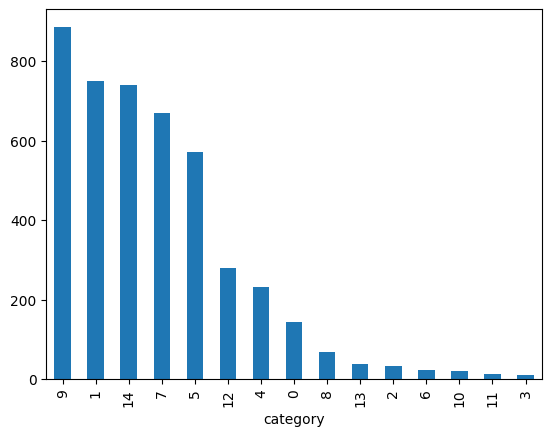

In [9]:
# @title category

from matplotlib import pyplot as plt

def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [10]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 15
Shape of the training data:  (3131, 12)
Shape of the test data:  (1343, 12)


In [11]:
model_checkpoint = "google/bert_uncased_L-2_H-128_A-2"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [12]:
from datasets import Dataset

def preprocess_function(input_data):
    # Extract features from input_data
    titles = input_data['title'].tolist()
    word_count = input_data['word_count'].tolist()
    character_count = input_data['character_count'].tolist()
    bigrams = input_data['bigrams'].tolist()
    lemma = input_data['lemma'].tolist()
    pos = input_data['pos'].tolist()
    tag = input_data['tag'].tolist()
    dep = input_data['dep'].tolist()
    context_score = input_data['context_score'].tolist()
    trigger_words = input_data['trigger_words'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Create a Dataset object
    dataset = Dataset.from_dict({
        'text': titles,
        'label': input_data[LABEL_COLUMN].tolist(),  # Assuming the label column name is LABEL_COLUMN
        'word_count': word_count,
        'character_count': character_count,
        'bigrams': bigrams,
        'lemma': lemma,
        'pos': pos,
        'tag': tag,
        'dep': dep,
        'context_score': context_score,
        'trigger_words': trigger_words,
        'input_ids': tokenized_inputs['input_ids'],
        'token_type_ids': tokenized_inputs['token_type_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    })

    return dataset

In [13]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
encoded_train

Dataset({
    features: ['text', 'label', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'context_score', 'trigger_words', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3131
})

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30522, 128, padding_idx=0)

In [28]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [29]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [30]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.792900,0.761003,0.827252
2,0.648600,0.701261,0.839911
3,0.559500,0.682346,0.835443
4,0.564700,0.642397,0.848101
5,0.490000,0.629124,0.848846
6,0.522100,0.624255,0.851080
7,0.460100,0.617867,0.851824
8,0.419100,0.615317,0.854058
9,0.408200,0.616185,0.856292
10,0.392300,0.620354,0.857036


TrainOutput(global_step=15660, training_loss=0.4466002940522604, metrics={'train_runtime': 299.4786, 'train_samples_per_second': 209.097, 'train_steps_per_second': 52.291, 'total_flos': 3120332056800.0, 'train_loss': 0.4466002940522604, 'epoch': 20.0})

In [32]:
trainer.evaluate()

{'eval_loss': 0.6178496479988098,
 'eval_f1': 0.8629932985852569,
 'eval_runtime': 2.8236,
 'eval_samples_per_second': 475.629,
 'eval_steps_per_second': 118.996,
 'epoch': 20.0}

In [33]:
bert_eval = trainer.evaluate(encoded_test)
bert_eval

{'eval_loss': 0.6178496479988098,
 'eval_f1': 0.8629932985852569,
 'eval_runtime': 2.9181,
 'eval_samples_per_second': 460.234,
 'eval_steps_per_second': 115.144,
 'epoch': 20.0}

In [34]:
predictions = trainer.predict(encoded_test)
predictions

PredictionOutput(predictions=array([[-1.5811614e+00, -1.1442510e+00, -1.2522250e+00, ...,
        -1.2357942e-01, -1.1351054e+00,  1.1257690e+00],
       [-1.1446440e+00,  7.9041481e+00, -1.5974228e+00, ...,
        -2.1615477e+00, -1.5968198e+00,  9.5048565e-01],
       [-1.3003341e+00,  8.1425712e-02, -1.8544178e+00, ...,
        -9.5089543e-01, -2.1068504e+00,  7.2731380e+00],
       ...,
       [-1.7438215e+00, -1.1836133e+00, -1.2603590e+00, ...,
        -3.3971292e-01, -1.1825233e+00,  1.0154138e+00],
       [-1.9602687e+00,  6.6626090e-01, -1.9542921e+00, ...,
        -1.5093576e+00, -2.2571447e+00, -2.2520330e-03],
       [-1.6743062e+00, -1.0300287e+00, -1.2293811e+00, ...,
        -2.6931444e-01, -1.1232059e+00,  1.1133974e+00]], dtype=float32), label_ids=array([ 5,  1, 14, ...,  5,  9,  5]), metrics={'test_loss': 0.6178496479988098, 'test_f1': 0.8629932985852569, 'test_runtime': 2.8854, 'test_samples_per_second': 465.446, 'test_steps_per_second': 116.448})

In [35]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

predicted_labels = predictions.predictions.argmax(axis=1)
ground_truth_labels = encoded_test["label"]

accuracy = accuracy_score(ground_truth_labels, predicted_labels)

In [36]:
print(accuracy)

0.8629932985852569
